In [1]:
# copy of poduv.m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import os

In [2]:
def read_vec_file(fname):
    data = np.genfromtxt(fname, skip_header=1, delimiter=',',usecols=(0,1,2,3,4))

    # how to convert into a 2D spatial field
    _x = np.unique(data[:,0])
    _y = np.unique(data[:,1])
    x,y = np.meshgrid(_x,_y)
    u,v,chc = np.zeros(x.shape), np.zeros(x.shape), np.zeros(x.shape)
    for row in range(len(data[:,0])):
        _x,_y,_u,_v,_chc = data[row,:]
        j,i = np.where(x==_x)[1][0], np.where(y==_y)[0][0]
        u[i,j],v[i,j],chc[i,j] = _u,_v,_chc
    return x,y,u,v,chc

In [3]:
# how to read a single file
fname = '../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec'
X,Y,U,V,CHC = read_vec_file(fname)

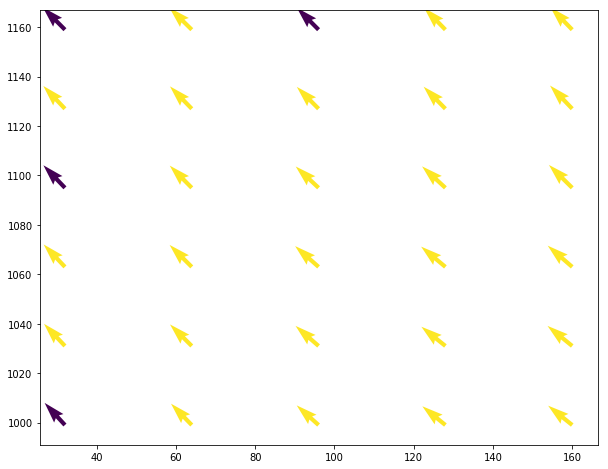

In [4]:
fig,ax = plt.subplots(figsize=(10,8))
ax.quiver(X,Y,U,V,CHC)
# ax.invert_yaxis()

In [5]:
list_of_vec_files = glob('../../small_test/*.vec')
list_of_vec_files.sort()
list_of_vec_files

['../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000201.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000202.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000203.T000.D000.P000.H000.L.vec']

In [6]:
u,v,chc = [],[],[]
for fname in list_of_vec_files:
    X,Y,_u,_v,_chc = read_vec_file(fname)
    u.append(_u)
    v.append(_v)
    chc.append(_chc)

u = np.stack(u)
v = np.stack(v)
chc = np.stack(chc)

In [7]:
chc.shape

(4, 6, 5)

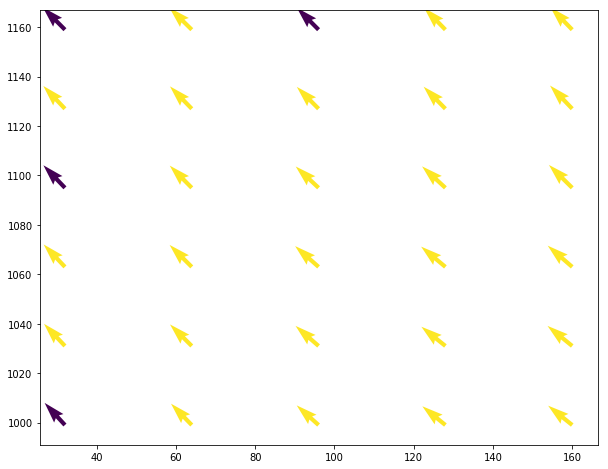

In [8]:
fig,ax = plt.subplots(figsize=(10,8))
ax.quiver(X,Y,u[0,:,:],v[0,:,:],chc[0,:,:])

In [9]:
def pod_modes(u,v,n_modes=None, method='snapshot'):
    """ estimates POD modes of a 2D vector field using a direct or a snapshot methods """
    N = len(u)
    r,c = u[0].shape

    # read data and rearrange in columns
    len1 = r*c

    U = np.zeros((len1*2,N)) # r*c*3 length of the vector

    # stack [u,v] together in columns
    for i in range(N):
        U[:len1,i] = np.reshape(u[i],len1,1)
        U[len1:,i] = np.reshape(v[i],len1,1)

    # fluctuations
    Uf = U.copy()
    Umean = np.mean(U,axis=1)
    for i in range(U.shape[1]):
        Uf[:,i] = U[:,i] - Umean

    if method is 'snapshot': # small size as number of snapshots
        R = np.dot(Uf.T,Uf)  # R = Uf.T@Uf equivalent expression
    elif method is 'direct': # large size as size of the PIV map
        R = np.dot(Uf,Uf.T)  # or R  = Uf@Uf.T

    print(R.shape)

    D,V = np.linalg.eig(R)

    # check consistency 
    assert (np.abs(np.dot(R,V) - np.dot(V,np.diag(D))).max() < 1e-11)

    _ = D/N
    L = np.sort(_)
    I = np.argsort(_)

    L = L[::-1]
    I = I[::-1]

    Erel = np.cumsum(L/np.sum(L))
    plt.figure()
    plt.plot(Erel[:N]*100)

    # modes
    if n_modes is None:
        n_modes = len(D) # all modes, otherwise change the number of modes
    if method is 'snapshot':
        S = np.sqrt(np.abs(D))
        S = S[I]
        V = V[:,I]
        a = np.diag(S[:n_modes])@V[:,:n_modes].T
        phi = Uf@V[:,:n_modes]@np.diag(1./S[:n_modes])
    elif method is 'direct':
        phi = V[:,I]
        a = np.dot(Uf.T,phi[:,:n_modes]).T
        phi = np.real(phi[:,:n_modes])
        
    umodes,vmodes = np.zeros((r,c,n_modes)),np.zeros((r,c,n_modes))
    for i in range(n_modes):
        umodes[:,:,i] = phi[:len1,i].reshape(r,c)
        vmodes[:,:,i] = phi[len1:,i].reshape(r,c)
    return umodes,vmodes

(60, 60)
(4, 4)


/Users/alex/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


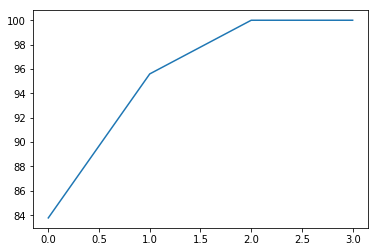

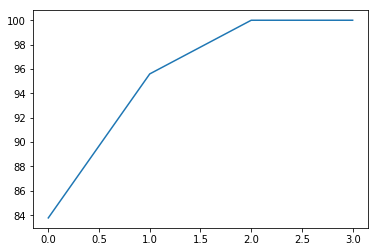

In [10]:
umd,vmd = pod_modes(u,v,method='direct')
ums,vms = pod_modes(u,v,method='snapshot')

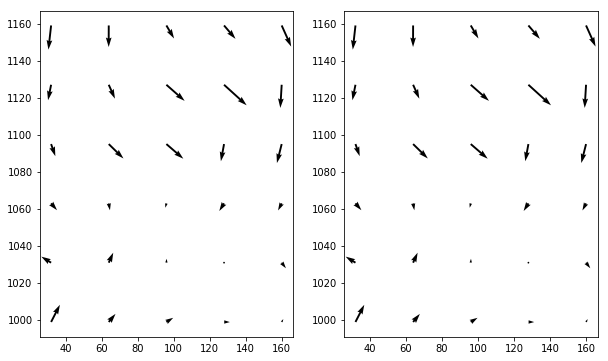

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].quiver(X,Y,umd[:,:,1],vmd[:,:,1])
ax[1].quiver(X,Y,ums[:,:,1],vms[:,:,1])

In [12]:
tmp = np.stack(u)

In [13]:
tmp.shape

(4, 6, 5)